# Preparación del entorno: instalaciones y librerías

In [1]:
#Instalaciones
!pip install -q datasets

In [2]:
#Librerías
import os
import pandas as pd
import glob
import shutil
from google.colab import drive
import torch.nn.functional as F
from torch.optim import Adam

#Semilla
SEED = 42

#Librerías donde fijar semilla para garantizar reproducibilidad
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback, set_seed
set_seed(SEED)
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import ParameterGrid

# Dataset

In [3]:
#Carga del dataset de España
dataset_es = load_dataset("alttal/balanced_SA_opiniones_indumentaria_ES_Espanya_splits")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
dataset_es

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3006
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 313
    })
})

# Métricas de evaluación

In [5]:
#Definimos las métricas para evaluar el modelo
#Este conjunto de métricas depende de la tarea.
#Para clasificación de textos se suelen utilizar accuracy, precision, recall y F1-score.

def compute_metrics(pred):
  y_true = pred.label_ids              # son las etiquetas reales
  y_pred = pred.predictions.argmax(-1) # son las predicciones
  acc = accuracy_score(y_true, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

  #métricas por clase
  precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

  #conversiones necesarias para evitar errores de registro en Tensorboard
  precision_per_class = list(precision_per_class)
  recall_per_class = list(recall_per_class)
  f1_per_class = list(f1_per_class)

  return {
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall,
      'precision_per_class': precision_per_class,
      'recall_per_class': recall_per_class,
      'f1_per_class': f1_per_class
  }

# Documentación del progreso

In [6]:
#Montar unidad de disco
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Ruta raíz para guardar cada experimento
path = '/content/drive/My Drive/TFM/Experimentos balanced'

#Cambiar directorio actual de trabajo
os.chdir(path)

#Verificar directorio actual
print("Directorio actual:", os.getcwd())

Directorio actual: /content/drive/My Drive/TFM/Experimentos balanced


In [8]:
#Definición de una función para eliminar logs antiguos (para evitar falta de almacenamiento)
def clean_old_logs(logging_dir, keep_last_n=1):
    log_files = sorted(glob.glob(os.path.join(logging_dir, '*')), key=os.path.getmtime)
    for log_file in log_files[:-keep_last_n]:
        os.remove(log_file)

In [9]:
#Ruta al directorio de logs
log_dir = path

#Eliminar archivos antiguos de TensorBoard (para evitar acumulación de demasiados logs)
for file in os.listdir(log_dir):
    if file.startswith('events.out.tfevents'):
        os.remove(os.path.join(log_dir, file))

# Modelo 1

##Carga del modelo 1 y adaptación de los datos

In [10]:
#Carga del modelo pre-entrenado
model1 = AutoModelForSequenceClassification.from_pretrained("finiteautomata/beto-sentiment-analysis", num_labels=3)

In [11]:
#A modo de información, vemos la configuración del modelo
model1.config

BertConfig {
  "_name_or_path": "finiteautomata/beto-sentiment-analysis",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31006
}

In [12]:
#¿Cómo son las etiquetas del modelo? Importante porque deben ser iguales a las del dataset
model1.config.id2label

{0: 'NEG', 1: 'NEU', 2: 'POS'}

##Tokenización del dataset

In [13]:
#Carga del tokenizador específico
tokenizer1 = AutoTokenizer.from_pretrained("finiteautomata/beto-sentiment-analysis")

In [14]:
#Se define tokenizador del primer modelo
def tokenize_function1(example):
    return tokenizer1(example["text"], padding='longest', truncation=True)

In [15]:
#Tokenización del dataset
encoded_dataset_es_1 = dataset_es.map(tokenize_function1, batched=True)
#Luego de tokenizar se puede eliminar la columna "text" porque el modelo no la necesita
encoded_dataset_es_1 = encoded_dataset_es_1.remove_columns(["text"])
encoded_dataset_es_1

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3006
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 625
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 313
    })
})

In [16]:
#Ejemplo de la tokenización en cada split
print(encoded_dataset_es_1['train'][0])
print(encoded_dataset_es_1['validation'][0])
print(encoded_dataset_es_1['test'][0])

{'label': 0, 'input_ids': [4, 1467, 1129, 15621, 1108, 3242, 1038, 1058, 1153, 17906, 1129, 7255, 17346, 1084, 7255, 26144, 30934, 1721, 1030, 22969, 1426, 1008, 1486, 1526, 6974, 21326, 9787, 1168, 1084, 1065, 2649, 1255, 5306, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Experimento 1.1

In [17]:
#Documentación
#Definición de directorios para el primer experimento
output_dir = "./outputs/model1_lit"
shutil.make_archive("./outputs/model1_lit", 'zip', output_dir)
logging_dir = "./logs/model1_lit"
shutil.make_archive("./logs/model1_lit", 'zip', output_dir)

#Si directorios no existen, crearlos
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

Entrenamiento con hiperparámetros recomendados

In [18]:
#Definición de EarlyStopping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,    # Número de épocas para esperar sin mejora
    early_stopping_threshold=0.0  # Umbral para la mejora mínima
)

In [19]:
#Definición de hiperparámetros
training_args_model1_lit = TrainingArguments(
    output_dir=output_dir,           # Directorio de salida
    logging_dir=logging_dir,         # Directorio para los logs
    eval_strategy="steps",           # Estrategia de evaluación
    save_strategy="steps",           # Estrategia de guardado (debe coincidir con la de evaluación)
    save_steps=1000,                 # Número de pasos entre cada guardado
    logging_strategy="steps",        # Estrategia de registro
    logging_steps=1000,              # Número de pasos entre cada registro
    num_train_epochs=3,              # Número de épocas de entrenamiento
    per_device_train_batch_size=16,  # Tamaño del batch de entrenamiento (podría ser también 32)
    per_device_eval_batch_size=16,   # Tamaño del batch de evaluación (podría ser también 32)
    learning_rate=3e-5,              # Tasa de aprendizaje
    weight_decay=0.01,               # Decadencia de peso (podría ser también 0.1)
    warmup_ratio=0.1,                # Proporción de épocas de calentamiento
    save_total_limit=1,              # Número máximo de checkpoints a guardar (para evitar problemas de almacenamiento)
    seed=SEED,                       # Semilla para garantizar reproducibilidad
    fp16=True,                       # Uso de fp16 para acelerar el entrenamiento
    load_best_model_at_end=True,     # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model="f1",      # Métrica objetivo, a optimizar para encontrar el mejor modelo
)

In [20]:
#Definición de optimizador
optimizer = Adam(model1.parameters(), lr=3e-5, weight_decay=0.01)

In [21]:
#Definición de un objeto de la clase Trainer para el primer experimento con el modelo 1
trainer_model1_lit = Trainer(
    model = model1,
    args = training_args_model1_lit,
    train_dataset = encoded_dataset_es_1['train'],
    eval_dataset = encoded_dataset_es_1['validation'],
    compute_metrics=compute_metrics,
    tokenizer = tokenizer1,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer1),
    optimizers = (optimizer, None),
    callbacks = [early_stopping])

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Entrenamiento

In [22]:
trainer_model1_lit.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=564, training_loss=0.5370270749355884, metrics={'train_runtime': 40.9072, 'train_samples_per_second': 220.45, 'train_steps_per_second': 13.787, 'total_flos': 1454789031368904.0, 'train_loss': 0.5370270749355884, 'epoch': 3.0})

Validación

In [23]:
trainer_model1_lit.evaluate()

Trainer is attempting to log a value of "[0.9217391304347826, 0.45, 0.8985507246376812]" of type <class 'list'> for key "eval/precision_per_class" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.848, 0.6, 0.8671328671328671]" of type <class 'list'> for key "eval/recall_per_class" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8833333333333334, 0.5142857142857143, 0.8825622775800711]" of type <class 'list'> for key "eval/f1_per_class" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.4480268657207489,
 'eval_accuracy': 0.8210862619808307,
 'eval_f1': 0.7600604417330397,
 'eval_precision': 0.7567632850241545,
 'eval_recall': 0.7717109557109557,
 'eval_precision_per_class': [0.9217391304347826, 0.45, 0.8985507246376812],
 'eval_recall_per_class': [0.848, 0.6, 0.8671328671328671],
 'eval_f1_per_class': [0.8833333333333334,
  0.5142857142857143,
  0.8825622775800711],
 'eval_runtime': 0.4609,
 'eval_samples_per_second': 679.063,
 'eval_steps_per_second': 43.391,
 'epoch': 3.0}

Reporte de clasificación (sobre conjunto de validación)

In [24]:
#Obtención de predicciones del conjunto de validación
predictions = trainer_model1_lit.predict(encoded_dataset_es_1['validation'])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Predicciones:")

#Generación del reporte (diccionario)
reporte_dict = classification_report(y_true, y_pred, output_dict=True)

#Reporte completo (texto)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

#Preparación de datos para el DataFrame
metrics_per_class = []
for label, metrics in reporte_dict.items():
    if label.isdigit():
        metrics_class = {
            "Clase": label,
            "Precisión": f"{metrics['precision']:.2f}",
            "Recall": f"{metrics['recall']:.2f}",
            "F1-score": f"{metrics['f1-score']:.2f}"
        }
        metrics_per_class.append(metrics_class)

#Creación de DataFrame con métricas por clase
df_metrics_per_class = pd.DataFrame(metrics_per_class)

Predicciones:
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       125
           1       0.45      0.60      0.51        45
           2       0.90      0.87      0.88       143

    accuracy                           0.82       313
   macro avg       0.76      0.77      0.76       313
weighted avg       0.84      0.82      0.83       313



In [25]:
#Limpiar logs antiguos
clean_old_logs(logging_dir, keep_last_n=1)

Test

Reporte de clasificación (sobre conjunto de test)

In [26]:
#Obtención de predicciones del conjunto de test
predictions = trainer_model1_lit.predict(encoded_dataset_es_1['test'])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Predicciones:")

#Generación del reporte (diccionario)
reporte_dict = classification_report(y_true, y_pred, output_dict=True)

#Reporte completo (texto)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

#Preparación de datos para el DataFrame
metrics_per_class = []
for label, metrics in reporte_dict.items():
    if label.isdigit():
        metrics_class = {
            "Clase": label,
            "Precisión": f"{metrics['precision']:.2f}",
            "Recall": f"{metrics['recall']:.2f}",
            "F1-score": f"{metrics['f1-score']:.2f}"
        }
        metrics_per_class.append(metrics_class)

#Creación de DataFrame con métricas por clase
df_metrics_per_class = pd.DataFrame(metrics_per_class)

Predicciones:
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       248
           1       0.43      0.60      0.50        90
           2       0.88      0.86      0.87       287

    accuracy                           0.80       625
   macro avg       0.74      0.76      0.74       625
weighted avg       0.83      0.80      0.81       625



In [27]:
#Limpiar logs antiguos
clean_old_logs(logging_dir, keep_last_n=1)

## Grid Search

Búsqueda de hiperparámetros optimizados con la técnica Grid Search:

In [28]:
#Definición del espacio de búsqueda
param_grid = {
    'num_train_epochs': [3, 5],
    'per_device_train_batch_size': [16, 32],
    'per_device_eval_batch_size': [16, 32],
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5, 1e-4],
    'weight_decay': [0.01, 0.1]
}

grid = ParameterGrid(param_grid)

In [29]:
#Función para calcular el f1-score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        'f1': f1_score(labels, predictions, average='macro')
    }

In [30]:
#Inicialización de variables para guardar los mejores resultados
best_score = 0
best_params = None

In [31]:
#Documentación
#Definición de directorios para el primer experimento
output_dir = "./outputs/model1_search"
shutil.make_archive("./outputs/model1_search", 'zip', output_dir)
logging_dir = "./logs/model1_search"
shutil.make_archive("./logs/model1_search", 'zip', output_dir)

#Si directorios no existen, crearlos
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

In [32]:
#Bucle para probar los diferentes parámetros
for params in grid:
    print(f"Entrenando con parámetros: {params}")

    #Definición de hiperparámetros
    training_args_model1_search = TrainingArguments(
        output_dir=output_dir,                                                  # Directorio de salida
        logging_dir=logging_dir,                                                # Directorio para los logs
        eval_strategy="steps",                                                  # Estrategia de evaluación
        save_strategy="steps",                                                  # Estrategia de guardado (debe coincidir con la de evaluación)
        save_steps=1000,                                                        # Número de pasos entre cada guardado
        logging_strategy="steps",                                               # Estrategia de registro
        logging_steps=1000,                                                     # Número de pasos entre cada registro
        num_train_epochs=params['num_train_epochs'],                            # Número de épocas de entrenamiento
        per_device_train_batch_size=params['per_device_train_batch_size'],      # Tamaño del batch de entrenamiento
        per_device_eval_batch_size=params['per_device_eval_batch_size'],        # Tamaño del batch de evaluación
        learning_rate=params['learning_rate'],                                  # Tasa de aprendizaje
        weight_decay=params['weight_decay'],                                    # Decadencia de peso
        save_total_limit=1,                                                     # Número máximo de checkpoints a guardar (para evitar problemas de almacenamiento)
        seed=SEED,                                                              # Semilla para garantizar reproducibilidad
        fp16=True,                                                              # Uso de fp16 para acelerar el entrenamiento
        load_best_model_at_end=True,                                            # Cargar el mejor modelo al final del entrenamiento
        metric_for_best_model='f1',                                             # Métrica objetivo, a optimizar para encontrar el mejor modelo
    )

    #Definición de un objeto de la clase Trainer para la búsqueda con el modelo 1
    trainer_model1_search = Trainer(
        model=model1,
        args=training_args_model1_search,
        train_dataset=encoded_dataset_es_1['train'],
        eval_dataset=encoded_dataset_es_1['validation'],
        tokenizer=tokenizer1,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer1),
        compute_metrics=compute_metrics,
        optimizers = (optimizer, None),
        callbacks = [early_stopping]
    )

    #Entrenamiento
    trainer_model1_search.train()

    #Limpiar logs antiguos después del entrenamiento en cada iteración
    clean_old_logs(logging_dir, keep_last_n=1)

    #Validación
    eval_result = trainer_model1_search.evaluate()

    #Guardamos métrica objetivo
    score = eval_result.get('eval_f1', 0)

    #Siempre que la métrica objetivo sea mejor que el score guardado hasta el momento, se lo actualiza
    if score > best_score:
        best_score = score
        best_params = params

#Vemos los resultados del Grid Search
print(f"Mejores parámetros: {best_params}")
print(f"Mejor puntuación F1: {best_score}")

Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 5e-05, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 3, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.01}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


Entrenando con parámetros: {'learning_rate': 0.0001, 'num_train_epochs': 5, 'per_device_eval_batch_size': 32, 'per_device_train_batch_size': 32, 'weight_decay': 0.1}


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss,Validation Loss


Mejores parámetros: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_eval_batch_size': 16, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}
Mejor puntuación F1: 0.7494002019704954


## Experimento 1.2.

In [33]:
#Documentación
#Definición de directorios para el segundo experimento
output_dir = "./outputs/model1_opt"
shutil.make_archive("./outputs/model1_opt", 'zip', output_dir)
logging_dir = "./logs/model1_opt"
shutil.make_archive("./logs/model1_opt", 'zip', output_dir)

#Si directorios no existen, crearlos
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

Entrenamiento con hiperparámetros optimizados

In [34]:
#Definición de EarlyStopping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,    # Número de épocas para esperar sin mejora
    early_stopping_threshold=0.0  # Umbral para la mejora mínima
)

In [35]:
#Definición de hiperparámetros (basados en Grid Search)
training_args_model1_opt = TrainingArguments(
    output_dir=output_dir,                                # Directorio de salida
    logging_dir=logging_dir,                              # Directorio para los logs
    eval_strategy="steps",                                # Estrategia de evaluación
    save_strategy="steps",                                # Estrategia de guardado (debe coincidir con la de evaluación)
    save_steps=1000,                                      # Número de pasos entre cada guardado
    logging_strategy="steps",                             # Estrategia de registro
    logging_steps=1000,                                   # Número de pasos entre cada registro
    num_train_epochs=3,                                   # Número de épocas de entrenamiento
    per_device_train_batch_size=16,                       # Tamaño del batch de entrenamiento
    per_device_eval_batch_size=16,                        # Tamaño del batch de evaluación
    learning_rate=1e-05,                                  # Tasa de aprendizaje
    weight_decay=0.1,                                     # Decadencia de peso
    save_total_limit=1,                                   # Número máximo de checkpoints a guardar (para evitar problemas de almacenamiento)
    seed=42,                                              # Semilla para garantizar reproducibilidad
    fp16=True,                                            # Uso de fp16 para acelerar el entrenamiento
    load_best_model_at_end=True,                          # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model="f1",                           # Métrica objetivo, a optimizar para encontrar el mejor modelo
)

In [36]:
#Definición de optimizador
optimizer = Adam(model1.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

In [37]:
#Definición de un objeto de la clase Trainer para el segundo experimento con el modelo 1
trainer_model1_opt = Trainer(
    model = model1,
    args = training_args_model1_opt,
    train_dataset = encoded_dataset_es_1['train'],
    eval_dataset = encoded_dataset_es_1['validation'],
    compute_metrics=compute_metrics,
    tokenizer = tokenizer1,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer1),
    optimizers = (optimizer, None),
    callbacks = [early_stopping])

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Entrenamiento

In [38]:
trainer_model1_opt.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=564, training_loss=0.94098051896332, metrics={'train_runtime': 41.7549, 'train_samples_per_second': 215.974, 'train_steps_per_second': 13.507, 'total_flos': 1454789031368904.0, 'train_loss': 0.94098051896332, 'epoch': 3.0})

Validación

In [39]:
trainer_model1_opt.evaluate()

{'eval_loss': 1.00131356716156,
 'eval_f1': 0.4566815900149233,
 'eval_runtime': 0.55,
 'eval_samples_per_second': 569.069,
 'eval_steps_per_second': 36.362,
 'epoch': 3.0}

Reporte de clasificación (sobre conjunto de validación)

In [40]:
#Obtención de predicciones del conjunto de validación
predictions = trainer_model1_opt.predict(encoded_dataset_es_1['validation'])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Predicciones:")

#Generación del reporte (diccionario)
reporte_dict = classification_report(y_true, y_pred, output_dict=True)

#Reporte completo (texto)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

#Preparación de datos para el DataFrame
metrics_per_class = []
for label, metrics in reporte_dict.items():
    if label.isdigit():
        metrics_class = {
            "Clase": label,
            "Precisión": f"{metrics['precision']:.2f}",
            "Recall": f"{metrics['recall']:.2f}",
            "F1-score": f"{metrics['f1-score']:.2f}"
        }
        metrics_per_class.append(metrics_class)

#Creación de DataFrame con métricas por clase
df_metrics_per_class = pd.DataFrame(metrics_per_class)

Predicciones:
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.64      0.18      0.29       125
           1       0.18      0.60      0.28        45
           2       0.86      0.76      0.81       143

    accuracy                           0.51       313
   macro avg       0.56      0.52      0.46       313
weighted avg       0.67      0.51      0.52       313



In [41]:
#Limpiar logs antiguos
clean_old_logs(logging_dir, keep_last_n=1)

Test

Reporte de clasificación (sobre conjunto de test)

In [42]:
#Obtención de predicciones del conjunto de test
predictions = trainer_model1_opt.predict(encoded_dataset_es_1['test'])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Predicciones:")

#Generación del reporte (diccionario)
reporte_dict = classification_report(y_true, y_pred, output_dict=True)

#Reporte completo (texto)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

#Preparación de datos para el DataFrame
metrics_per_class = []
for label, metrics in reporte_dict.items():
    if label.isdigit():
        metrics_class = {
            "Clase": label,
            "Precisión": f"{metrics['precision']:.2f}",
            "Recall": f"{metrics['recall']:.2f}",
            "F1-score": f"{metrics['f1-score']:.2f}"
        }
        metrics_per_class.append(metrics_class)

#Creación de DataFrame con métricas por clase
df_metrics_per_class = pd.DataFrame(metrics_per_class)

Predicciones:
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.24      0.35       248
           1       0.21      0.72      0.33        90
           2       0.87      0.70      0.78       287

    accuracy                           0.52       625
   macro avg       0.59      0.55      0.49       625
weighted avg       0.70      0.52      0.54       625



In [43]:
#Limpiar logs antiguos
clean_old_logs(logging_dir, keep_last_n=1)

## Experimento extra 1.3

In [44]:
#Documentación
#Definición de directorios para el tercer experimento
output_dir = "./outputs/model1_est"
shutil.make_archive("./outputs/model1_est", 'zip', output_dir)
logging_dir = "./logs/model1_est"
shutil.make_archive("./logs/model1_est", 'zip', output_dir)

#Si directorios no existen, crearlos
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

Entrenamiento con hiperparámetros originales

In [45]:
#Definición de hiperparámetros estándar
training_args_model1_estandar = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    logging_strategy="steps",
    logging_steps=1000,
    seed=SEED,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

In [46]:
#Definición de un objeto de la clase Trainer para el tercer experimento con el modelo 1
trainer_model1_estandar = Trainer(
    model = model1,
    args = training_args_model1_estandar,
    train_dataset = encoded_dataset_es_1['train'],
    eval_dataset = encoded_dataset_es_1['validation'],
    compute_metrics=compute_metrics,
    tokenizer = tokenizer1,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer1)
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Entrenamiento

In [47]:
trainer_model1_estandar.train()

Step,Training Loss,Validation Loss,F1
1000,0.629100,0.816650,0.653419


TrainOutput(global_step=1128, training_loss=0.5989944241571088, metrics={'train_runtime': 74.448, 'train_samples_per_second': 121.132, 'train_steps_per_second': 15.152, 'total_flos': 1446468069533256.0, 'train_loss': 0.5989944241571088, 'epoch': 3.0})

Validación

In [48]:
trainer_model1_estandar.evaluate()

{'eval_loss': 0.8166504502296448,
 'eval_f1': 0.6534192624418189,
 'eval_runtime': 0.916,
 'eval_samples_per_second': 341.717,
 'eval_steps_per_second': 43.67,
 'epoch': 3.0}

Reporte de clasificación (sobre conjunto de validación)

In [49]:
#Obtención de predicciones del conjunto de validación
predictions = trainer_model1_estandar.predict(encoded_dataset_es_1['validation'])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Predicciones:")

#Generación del reporte (diccionario)
reporte_dict = classification_report(y_true, y_pred, output_dict=True)

#Reporte completo (texto)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

#Preparación de datos para el DataFrame
metrics_per_class = []
for label, metrics in reporte_dict.items():
    if label.isdigit():
        metrics_class = {
            "Clase": label,
            "Precisión": f"{metrics['precision']:.2f}",
            "Recall": f"{metrics['recall']:.2f}",
            "F1-score": f"{metrics['f1-score']:.2f}"
        }
        metrics_per_class.append(metrics_class)

#Creación de DataFrame con métricas por clase
df_metrics_per_class = pd.DataFrame(metrics_per_class)

Predicciones:
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       125
           1       0.31      0.36      0.33        45
           2       0.84      0.83      0.84       143

    accuracy                           0.74       313
   macro avg       0.65      0.65      0.65       313
weighted avg       0.75      0.74      0.75       313



In [50]:
#Limpiar logs antiguos
clean_old_logs(logging_dir, keep_last_n=1)

Test

Reporte de clasificación (sobre conjunto de test)

In [51]:
#Obtención de predicciones del conjunto de test
predictions = trainer_model1_estandar.predict(encoded_dataset_es_1['test'])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Predicciones:")

#Generación del reporte (diccionario)
reporte_dict = classification_report(y_true, y_pred, output_dict=True)

#Reporte completo (texto)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

#Preparación de datos para el DataFrame
metrics_per_class = []
for label, metrics in reporte_dict.items():
    if label.isdigit():
        metrics_class = {
            "Clase": label,
            "Precisión": f"{metrics['precision']:.2f}",
            "Recall": f"{metrics['recall']:.2f}",
            "F1-score": f"{metrics['f1-score']:.2f}"
        }
        metrics_per_class.append(metrics_class)

#Creación de DataFrame con métricas por clase
df_metrics_per_class = pd.DataFrame(metrics_per_class)

Predicciones:
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       248
           1       0.35      0.31      0.33        90
           2       0.82      0.78      0.80       287

    accuracy                           0.72       625
   macro avg       0.64      0.63      0.63       625
weighted avg       0.72      0.72      0.72       625



In [52]:
#Limpiar logs antiguos
clean_old_logs(logging_dir, keep_last_n=1)

## Experimento final: mejor modelo, nuevo dataset

In [57]:
#Elección del mejor modelo
#Modelo final -> Modelo con hiperparámetros recomendados
#Carga del nuevo dataset: comentarios de Argentina
dataset_ar = load_dataset("alttal/SA_opiniones_indumentaria_ES_Argentina_splits")

In [58]:
#Unimos los splits: sólo necesitaremos uno para el test
from datasets import concatenate_datasets
dataset_ar = concatenate_datasets([dataset_ar['train'], dataset_ar['test'], dataset_ar['validation']])

#Ejemplo
print(dataset_ar)

Dataset({
    features: ['id', 'label', 'text', '__index_level_0__'],
    num_rows: 3125
})


In [59]:
#Se eliminan columnas innecesarias
dataset_ar = dataset_ar.remove_columns(["id","__index_level_0__"])
dataset_ar

Dataset({
    features: ['label', 'text'],
    num_rows: 3125
})

In [60]:
#Las etiquetas de los datasets son strings. Se las cambia a valores numéricos
def label_to_int(label):
    if label == "POS":
        return 2
    elif label == "NEG":
        return 0
    else:
        return 1

dataset_ar_1 = dataset_ar.map(lambda x: {"label": label_to_int(x["label"])})

In [61]:
#Tokenización del dataset
encoded_dataset_ar_1 = dataset_ar_1.map(tokenize_function1, batched=True)
#Luego de tokenizar se puede eliminar la columna "text" porque el modelo no la necesita
encoded_dataset_ar_1 = encoded_dataset_ar_1.remove_columns(["text"])
encoded_dataset_ar_1

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3125
})

Reporte de clasificación sobre el conjunto de datos de Argentina

In [62]:
#Obtención de predicciones del conjunto de test
predictions = trainer_model1_lit.predict(encoded_dataset_ar_1)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

print("Predicciones:")

#Generación del reporte (diccionario)
reporte_dict = classification_report(y_true, y_pred, output_dict=True)

#Reporte completo (texto)
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred))

#Preparación de datos para el DataFrame
metrics_per_class = []
for label, metrics in reporte_dict.items():
    if label.isdigit():
        metrics_class = {
            "Clase": label,
            "Precisión": f"{metrics['precision']:.2f}",
            "Recall": f"{metrics['recall']:.2f}",
            "F1-score": f"{metrics['f1-score']:.2f}"
        }
        metrics_per_class.append(metrics_class)

#Creación de DataFrame con métricas por clase
df_metrics_per_class = pd.DataFrame(metrics_per_class)

Predicciones:
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.51      0.76      0.61       703
           1       0.28      0.28      0.28       333
           2       0.91      0.75      0.82      2089

    accuracy                           0.71      3125
   macro avg       0.56      0.60      0.57      3125
weighted avg       0.75      0.71      0.72      3125



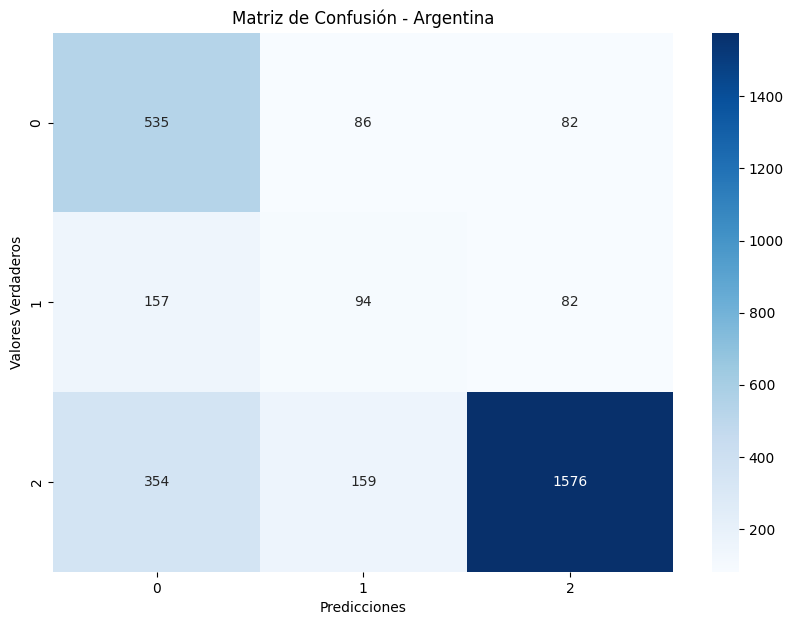

In [63]:
#Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

#Configuración del gráfico
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión - Argentina')
plt.show()